In [1]:
from brian2 import *
import csv
%matplotlib inline

def visualise_connectivity(S):
    Ns = len(S.source)
    Nt = len(S.target)
    figure(figsize=(20, 10))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10)
    plot(ones(Nt), arange(Nt), 'ok', ms=10)
    for i, j in zip(S.i, S.j):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)
    ylim(-1, max(Ns, Nt))
    subplot(122)
    plot(S.i, S.j, 'ok')
    xlim(-1, Ns)
    ylim(-1, Nt)
    xlabel('Source neuron index')
    ylabel('Target neuron index')

    
def visualise_plasticity(t, rho, sample=10):
    #figure()
    for i in range(min(sample, rho.shape[0])):
        plot(t, rho[i])

In [ ]:
start_scope()

#control parameters
debug = True
simulation_length = 250
observe_window = 10
N = 10000

F = 1000*Hz

#Variables used in brian code
cpre_0 = 0.1
cpost_0 = 0.1
rho_0 = 0.2
c = 0.2
dummy = 0.2
Ipre = 0
Ipost = 0
w0 = 0.5


#LIF specific constants
tau_lif = 260*ms
V_init = -60
V_rest = -70
V_reset = -70
V_threshold = -50
CM = 0.001
RM = 20.0
sigma = 5
#sigma = 3.3501
#sigma = 0
refrac = 0


#Synapse model specific constants
rho_init = 0.019
ca_initial = 0
ca_delay = 4.61 #ms
Cpre = 0.56175
Cpost = 1.23964
tau_ca = 22.6936
theta_D = 1
theta_P = 1.3
gamma_D = 331.909
gamma_P = 725.085

taurho = 346361*ms
taurho_fast = 10*ms # dummy
taupre = taupost = tau_ca = 22*ms
rho_star = 0.5
D = 4.6098
#v_ext = 30*mV


lif_eqs = '''
dv/dt = (- v + I_ext) / tau_lif + sigma*xi*tau_lif**-0.5 : 1
I_ext : 1
'''
#P = PoissonGroup(N, rates=F)
# = NeuronGroup(2, eqs, threshold='v>vt', reset='v = vr')
G = NeuronGroup(N, lif_eqs, threshold='v>V_threshold', reset='v = V_rest')
#S = Synapses(G, G, pre='v+=1*mV', connect='i==0 and j==1')
G.v = V_init
#drho = (-rho*(1-rho)*(0.5-rho) ) / taurho : 1
S = Synapses(G, G,
            model = 
            '''
            w : 1 
            dcpre/dt = -cpre / taupre : 1
            dcpost/dt = -cpost / taupost : 1
            c = cpre + cpost : 1
            dummy = (c>theta_D) : 1
            drho/dt = (-rho*(1-rho)*(0.5-rho) + gamma_P*(1-rho)*(c>theta_P) - gamma_D*rho*(c>theta_D)) / taurho : 1
            ''',
            pre =
            '''
            v_post += w
            cpre += Cpre
            
            ''',
            post = 
            '''
            cpost += Cpost
            
            ''')
#S.connect('i==0 and j!=0', p=1.0)
S.connect('i!=j', p=0.1)

#tmp = ((np.arange(len(S))+1) * 4).tolist()
#S.delay = tmp*ms
#S.delay = [4, 40, 400, 4000]*ms
S.w = w0
S.cpre = cpre_0
S.cpost= cpost_0
S.rho = rho_0
G.I_ext = [0] * N
G.I_ext[0] = 1

#statemon = StateMonitor(G, 'v', record = True)
#spikemon = SpikeMonitor(G)

# Unrecorded simulation
run((simulation_length-observe_window)*ms, report='stdout', report_period=1*second)

# Recorded simulation
statemon_S = StateMonitor(S, ['rho'], record = True, dt=0.1*ms)
run(observe_window*ms, report='stdout', report_period=1*second)

# Write to a csv file


Starting simulation for duration 240. ms
1.2 ms (0%) simulated in 1s, estimated 3m 25s remaining.
3.1 ms (1%) simulated in 2s, estimated 2m 39s remaining.
5. ms (2%) simulated in 3s, estimated 2m 27s remaining.
6.9 ms (2%) simulated in 4s, estimated 2m 22s remaining.
8.8 ms (3%) simulated in 5s, estimated 2m 18s remaining.
10.7 ms (4%) simulated in 6s, estimated 2m 15s remaining.
12.6 ms (5%) simulated in 7s, estimated 2m 13s remaining.
14.5 ms (6%) simulated in 8s, estimated 2m 11s remaining.
16.4 ms (6%) simulated in 9s, estimated 2m 9s remaining.
18.3 ms (7%) simulated in 10s, estimated 2m 7s remaining.
20.2 ms (8%) simulated in 11s, estimated 2m 6s remaining.
22.1 ms (9%) simulated in 12s, estimated 2m 4s remaining.
23.3 ms (9%) simulated in 13s, estimated 2m 7s remaining.
23.6 ms (9%) simulated in 14s, estimated 2m 16s remaining.
23.9 ms (9%) simulated in 16s, estimated 2m 25s remaining.
24.2 ms (10%) simulated in 17s, estimated 2m 34s remaining.
24.5 ms (10%) simulated in 18s, es

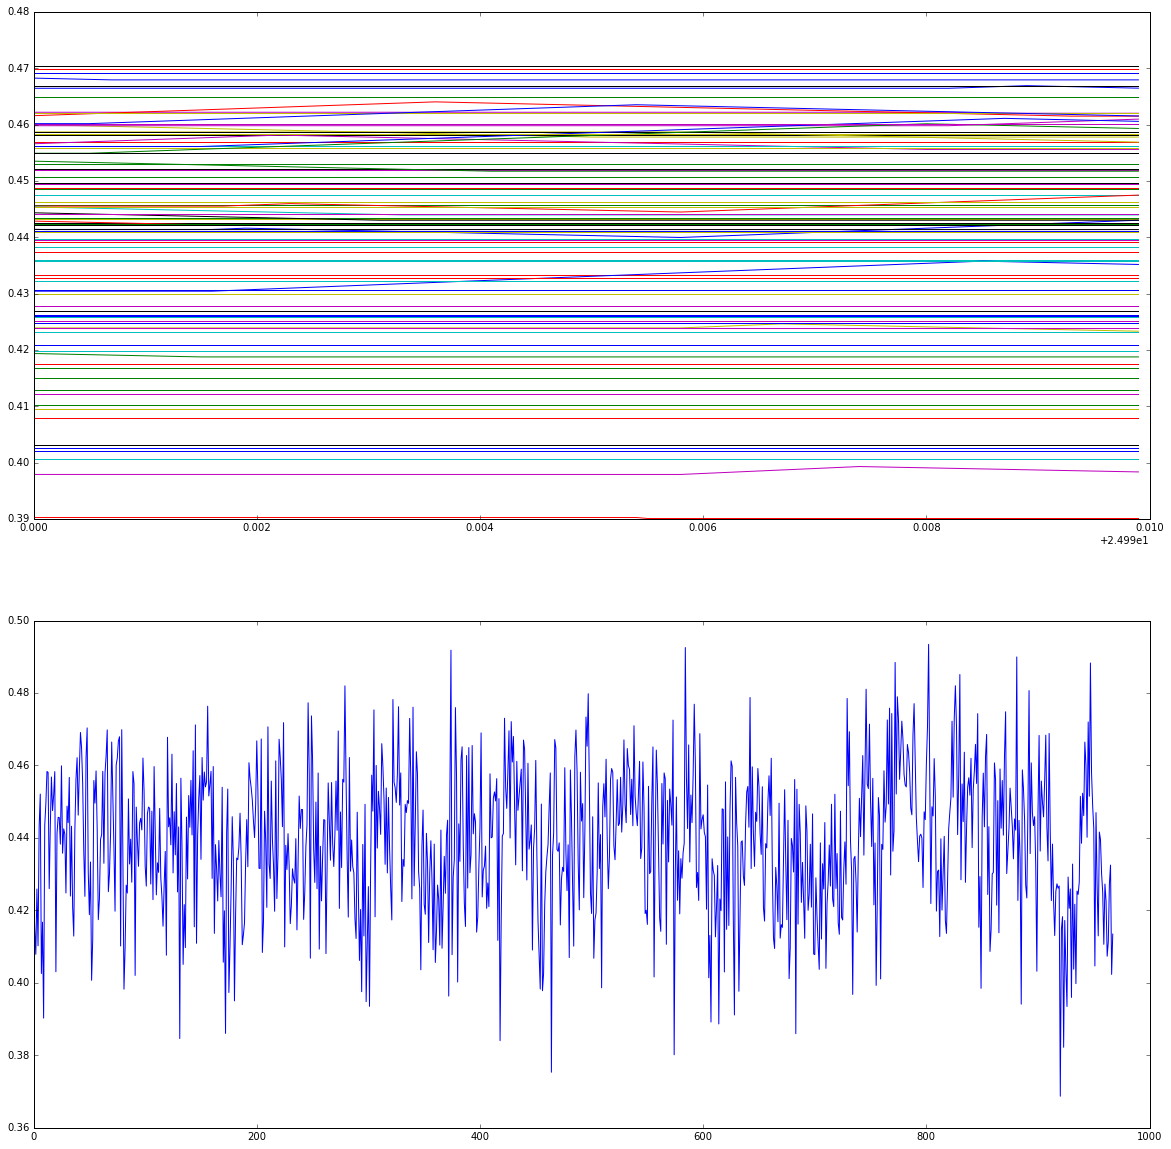

In [3]:
if debug:
    p1 = figure(1, figsize=(20,20))
    subplot(211)
    visualise_plasticity(statemon_S.t, statemon_S.rho, sample=100)
    subplot(212)
    np_rho = np.array(statemon_S.rho)
    stable_rho = np.mean(np_rho, axis=1)


    plot(stable_rho)
#Analysis
else:
    print statemon_S.rho
    


In [ ]:
# 4 phase simulation, resting -> 250ms/ 650ms presentation of stim -> resting -> represent